# Text Classification 
## Basic ML algorithms VS Recurrent Neural Networks

### User's choice. Set parameters or use pre-chosen ones:

In [36]:
choice = input('Chose hyperparameters: yes / no')

if choice == 'yes':
    import params
    VOCAB_SIZE = params.VOCAB_SIZE
    MAXLEN = params.MAXLEN
    EMBEDDING_DIM = params.EMBEDDING_DIM
    dropout = params.dropout
    LearningRate = params.LearningRate

Installing requirements

In [37]:
!pip install -r requirements.txt

In [38]:
%matplotlib inline

Importing libraries

In [39]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict
import nltk
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
import re
import time
import nltk as nlp
import math
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
import tensorflow as tf 
from evaluation import GetScoresNN, GetModelScores, GetScores
from plot_functions import plot_accuracy_curve, plot_loss_curve, plot_length_sentences, plot_distribution, confusion_matrix_NN

In [40]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.metrics import classification_report, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

In [41]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Dense, SimpleRNN, LSTM, Bidirectional, GlobalAveragePooling1D, Dropout, Attention, TimeDistributed, GlobalMaxPooling1D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
import tensorflow_hub as hub

In [42]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cristiano/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Hyperparameters

In [44]:
TRAIN_PCT = 0.8
VAL_PCT = 0.1
TEST_PCT = 0.1

VOCAB_SIZE = 8000
MAXLEN = 20
EMBEDDING_DIM = 32

# Import Data

### Data set: Clickbait

This dataset contains headlines from various news sites such as ‘WikiNews’, ’New York Times’, ‘The
Guardian’, ‘The Hindu’, ‘BuzzFeed’, ‘Upworthy’, ‘ViralNova’, ‘Thatscoop’, ‘Scoopwhoop’ and ‘Viral-
Stories’. It has two columns first one contains headlines and the second one has numerical labels
of clickbait in which 1 represents that it is clickbait and 0 represents that it is non-clickbait head-
line. The dataset contains total 32000 rows of which half of them are clickbait and the other half are
non-clickbait.

Source - "https://github.com/bhargaviparanjape/clickbait"

In [45]:
data = pd.read_csv("clickbait.csv")
data=data[['text', 'labels']]
data['text'] = data['text'].astype(str)
data['labels'] = data['labels'].astype(int)
data = data.sample(frac=1)
data = data.reset_index(drop=True)
data

,text,labels
0,Taliban Seize Vital Pakistan Area Closer to th...,0
1,Reports: Parents of missing girl Madeleine McC...,0
2,Wider Drug War Threatens Colombian Indians,0
3,People Reacted To The Online Sensation #AlDub ...,1
4,26 #BlackOutEid Selfies That Will Completely M...,1
...,...,...
31995,Pizza 'lust' campaign attracts numerous compla...,0
31996,South Korean navy ship sinks off North Korean ...,0
31997,Apple executive leaves company after iPhone 4 ...,0
31998,"This Is What ""Mean Girls"" Would Be Like If It ...",1


# Training - Test - Validation split

In [46]:
def train_test_val_split(data) :

    train_data = pd.DataFrame()
    val_data = pd.DataFrame()
    test_data = pd.DataFrame()

    for (label, group_texts) in data.groupby('labels'):

        group_texts = group_texts.sample(len(group_texts))  ## shuffle the data for each group

        train_data_end_index = int(len(group_texts) * TRAIN_PCT)
        val_data_end_index = train_data_end_index + int(len(group_texts) * VAL_PCT)


        train_data_in_group = group_texts[:train_data_end_index]
        val_data_in_group = group_texts[train_data_end_index:val_data_end_index]
        test_data_in_group = group_texts[val_data_end_index :]

        train_data = train_data.append(train_data_in_group)
        val_data = val_data.append(val_data_in_group)
        test_data = test_data.append(test_data_in_group)
        
    return train_data, val_data, test_data

In [47]:
train_data1, val_data1, test_data1 = train_test_val_split(data)

<ipython-input-46-9137dd1aeb6d>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(train_data_in_group)
<ipython-input-46-9137dd1aeb6d>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  val_data = val_data.append(val_data_in_group)
<ipython-input-46-9137dd1aeb6d>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(test_data_in_group)
<ipython-input-46-9137dd1aeb6d>:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(train_data_in_group)
<ipython-input-46-9137dd1aeb6d>:20: FutureWarning: The frame.append method is deprecated and will be removed from pan

In [48]:
print("Train data shape:", train_data1.shape)
print("Test data shape:", test_data1.shape)
print("Validiation data shape:", val_data1.shape)

Train data shape: (25599, 2)
Test data shape: (3202, 2)
Validiation data shape: (3199, 2)


# Inspection of data

In [49]:
train_data1.labels.value_counts(), test_data1.labels.value_counts()

(0    12800
 1    12799
 Name: labels, dtype: int64,
 0    1601
 1    1601
 Name: labels, dtype: int64)

### Distribution among classes for training, test and validation data

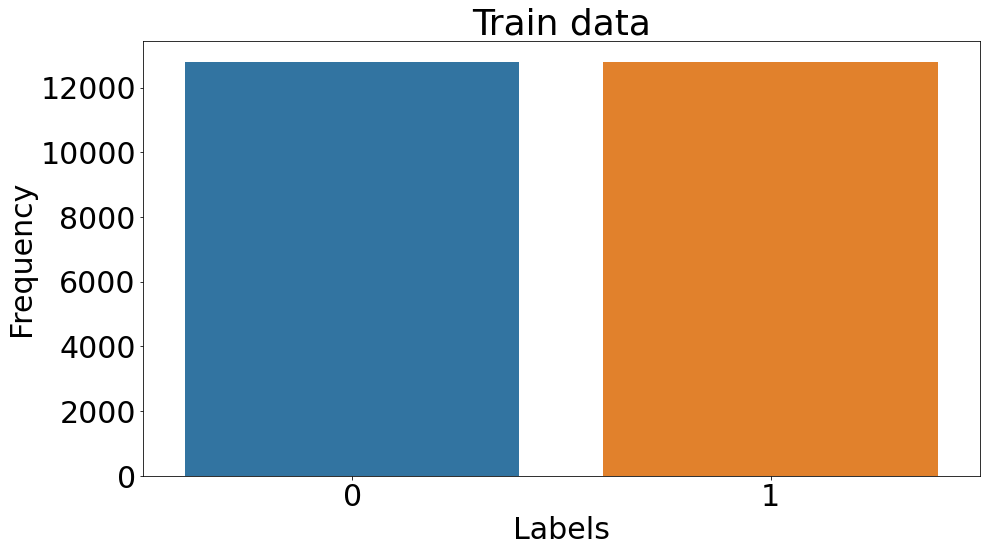

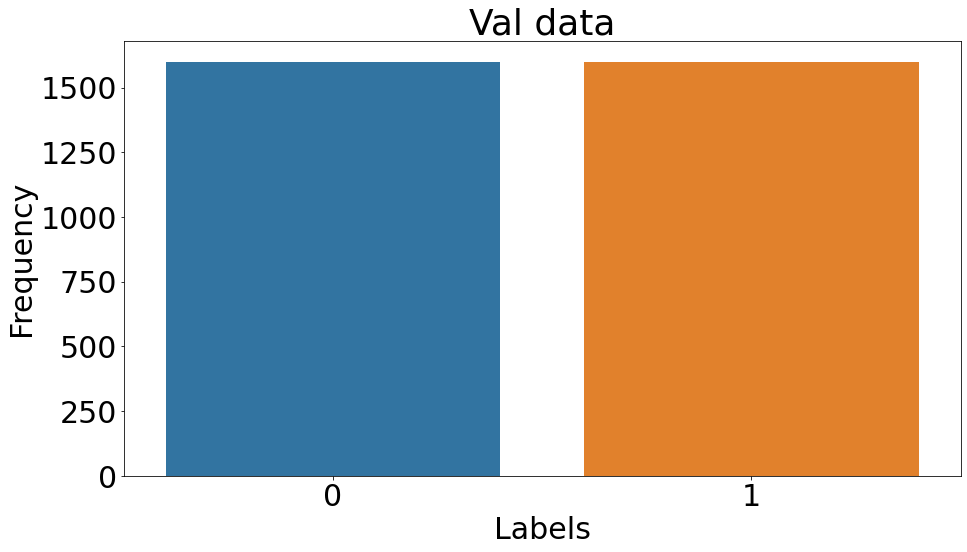

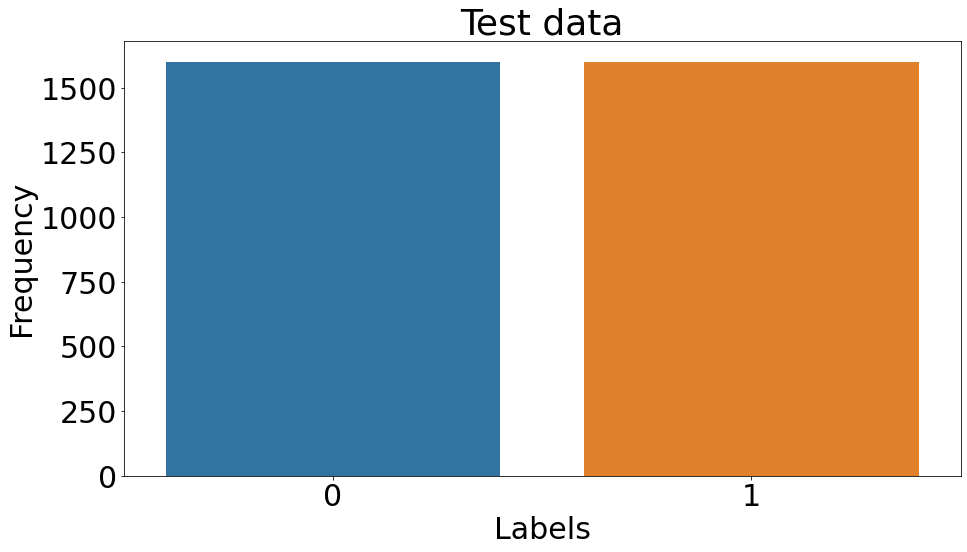

In [50]:
plot_distribution(train_data1, 'Train')
plot_distribution(val_data1, 'Val')
plot_distribution(test_data1, 'Test')

The number of samples belonging to class 0 (Non clickbait) and 1 (Clickbait) is perfectly balanced and we do not need to resample.

In [51]:
labels_dict1 = {
    'Non_Clickbait': 0,
    'Clickbait': 1
}

### Distribution of length of sentences

/home/cristiano/anaconda3/envs/ml/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


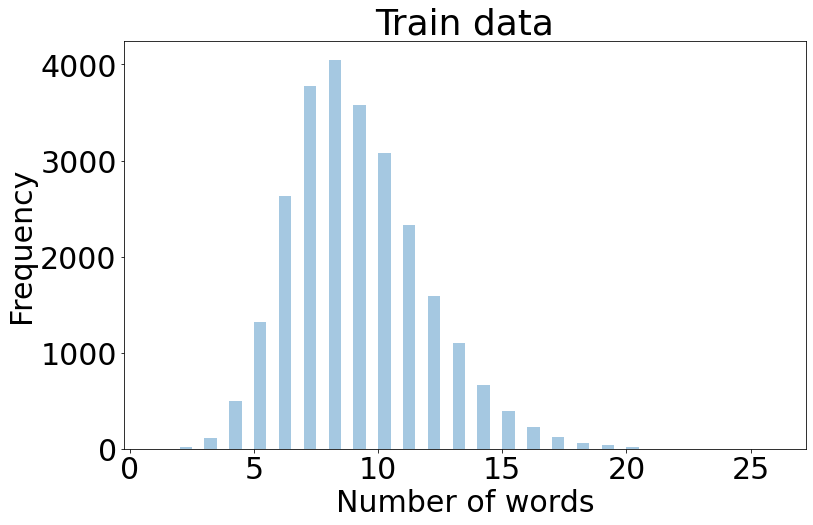

/home/cristiano/anaconda3/envs/ml/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


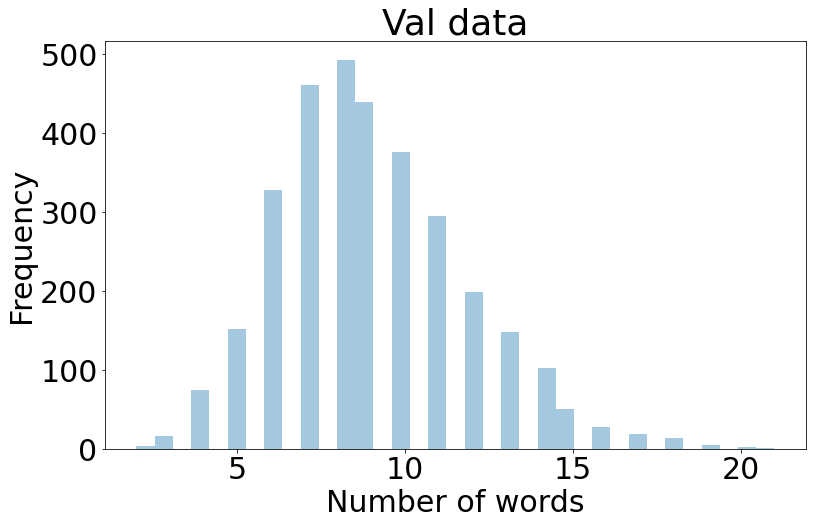

/home/cristiano/anaconda3/envs/ml/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


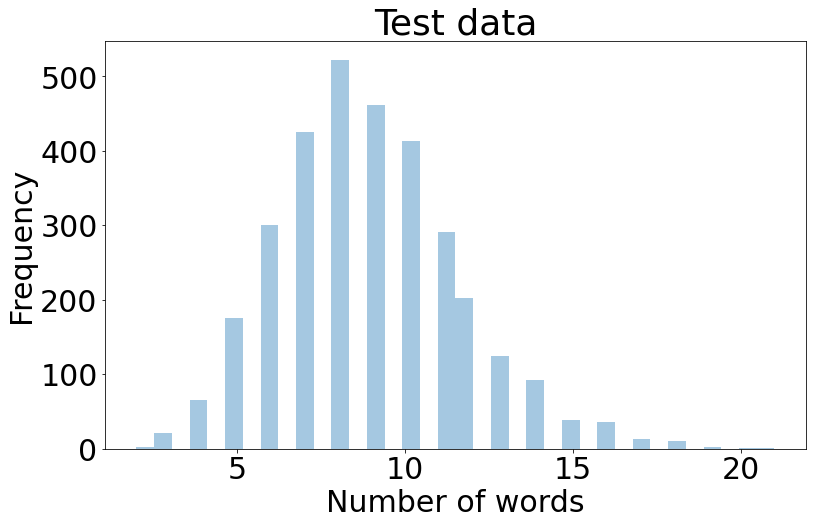

In [52]:
plot_length_sentences(train_data1, 'Train')
plot_length_sentences(val_data1, 'Val')
plot_length_sentences(test_data1, 'Test')

Here we can see that the majority of each document contains within 20 - 40 tokens. That is good because we dont have really long seqences of words.

This is only by the text column. I didn't include the title in this. 

# Text Preprocessing 
## Feature extraction

In [53]:
def keras_tokenize(train, val, test) :
    tokenizer = Tokenizer(num_words=8000, lower=True)
    tokenizer.fit_on_texts(train.text.values)

    # Create and Fit tokenizer
    X_train = tokenizer.texts_to_sequences(train.text.values)
    X_val = tokenizer.texts_to_sequences(val.text.values)
    X_test = tokenizer.texts_to_sequences(test.text.values)
    
    return X_train, X_val, X_test

In [54]:
def pad_tokenize(X_train, X_val, X_test, maxlen=MAXLEN) :
    # Pad data
    X_train_padded = pad_sequences(X_train, padding="post", truncating="post", maxlen=maxlen)
    X_val_padded = pad_sequences(X_val, padding="post", truncating="post", maxlen=maxlen)
    X_test_padded = pad_sequences(X_test, padding="post", truncating="post", maxlen=maxlen)
    
    return X_train_padded, X_val_padded, X_test_padded

In [55]:
def count_tokenize(train, val, test) :
    vect = CountVectorizer(max_features=8000, stop_words="english")

    train_bow = vect.fit_transform(train.text.values)
    val_bow = vect.transform(val.text.values)
    test_bow = vect.transform(test.text.values)
    
    return train_bow, val_bow, test_bow

In [56]:
X_train1, X_val1, X_test1 = keras_tokenize(train_data1, val_data1, test_data1)

In [57]:
X_train_padded1, X_val_padded1, X_test_padded1 = pad_tokenize(X_train1, X_val1, X_test1)

In [58]:
X_train_padded1[0]

array([ 172,  759,  878,  517,    2,  647,  388, 5635, 6713,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32)

In [59]:
train_bow1, val_bow1, test_bow1 = count_tokenize(train_data1, val_data1, test_data1)

# Basic Machine Learning algorithms

LogisticRegression, DecisionTreeClassifier and RandomForestClassifier

In [60]:
GetModelScores(LogisticRegression(), train_bow1, val_bow1, train_data1.labels, val_data1.labels)

   Accuracy  F1 Score  Precision    Recall   ROC_AUC
0  0.952798  0.952798   0.952802  0.952798  0.990689
Inference time:  0.18517494201660156


In [61]:
GetModelScores(DecisionTreeClassifier(), train_bow1, val_bow1, train_data1.labels, val_data1.labels)

   Accuracy  F1 Score  Precision    Recall   ROC_AUC
0  0.862457  0.861414   0.873754  0.862457  0.882014
Inference time:  3.1349127292633057


In [62]:
GetModelScores(KNeighborsClassifier(), train_bow1, val_bow1, train_data1.labels, val_data1.labels)

   Accuracy  F1 Score  Precision    Recall   ROC_AUC
0  0.605502   0.54441   0.727886  0.605502  0.741945
Inference time:  3.9825973510742188


Since the kNN classifier clearly yields worse results, we only tune Logistic Regression and Decision Tree.

### Parameter tuning via Cross Validation

In [63]:
parameters_lr = {
    "C": [0.1, 0.01, 1, 0.001]
}

parameters_dt = {
    "max_depth": [10, 50, 100, None],
    "min_samples_split": [2, 5, 10],
}

In [64]:
def search_lr(train_bow, train_data) :
    start = time.time()

    grid = GridSearchCV(LogisticRegression(), parameters_lr, scoring = 'accuracy', cv = 5, n_jobs =-1)
    grid.fit(train_bow, train_data.labels)

    end = time.time()
    print("Inference time: ", end-start)
    
    return grid

def search_dt(train_bow, train_data) :
    start = time.time()

    grid = GridSearchCV(DecisionTreeClassifier(), parameters_dt, scoring = 'accuracy', cv = 5, n_jobs =-1)
    grid.fit(train_bow, train_data.labels)

    end = time.time()
    print("Inference time: ", end-start)
    
    return grid

In [65]:
grid_lr = search_lr(train_bow1, train_data1)
grid_dt = search_dt(train_bow1, train_data1)

Inference time:  2.643157482147217
Inference time:  17.72532844543457


In [66]:
print(grid_lr.best_estimator_)
print(grid_dt.best_estimator_)

LogisticRegression(C=1)
DecisionTreeClassifier(min_samples_split=5)


In [67]:
print(grid_lr.best_params_)
print(grid_dt.best_params_)

{'C': 1}
{'max_depth': None, 'min_samples_split': 5}


In [68]:
print('Logistic Regression')
GetScores(grid_lr, train_bow1, val_bow1, train_data1.labels, val_data1.labels)
print('Decision Tree Classifier')
GetScores(grid_dt, train_bow1, val_bow1, train_data1.labels, val_data1.labels)

Logistic Regression
   Accuracy  F1 Score  Precision    Recall   ROC_AUC
0  0.952798  0.952798   0.952802  0.952798  0.990689
Inference time:  0.019135713577270508
Decision Tree Classifier
   Accuracy  F1 Score  Precision    Recall   ROC_AUC
0  0.886527  0.886326   0.889303  0.886527  0.917014
Inference time:  0.03557085990905762


/home/cristiano/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 1440x1440 with 0 Axes>

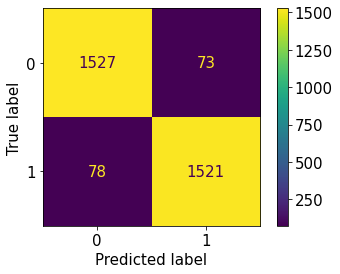

In [69]:
plt.figure(figsize=(20,20))
plt.rc('font', size=15)
plot_confusion_matrix(grid_lr, val_bow1, val_data1.labels)
plt.savefig('confusion_ml_click.pdf', dpi='figure')
# plot_confusion_matrix(grid_dt, val_bow1, val_data1.labels)

# Recurrent Neural Networks

### Simple RNN

In [70]:
tf.keras.backend.clear_session()

In [75]:
LearningRate = 0.001
dropout = 0.1

In [76]:
X_train_padded1

array([[ 172,  759,  878, ...,    0,    0,    0],
       [ 146, 1145, 5636, ...,    0,    0,    0],
       [  19,  160, 1220, ...,    0,    0,    0],
       ...,
       [ 515,   74,  175, ...,    0,    0,    0],
       [  26, 2272,  666, ...,    0,    0,    0],
       [ 729, 1036, 1724, ...,    0,    0,    0]], dtype=int32)

Most simple rnn

Epoch 1/10
25/25 [==============================] - 2s 24ms/step - loss: 0.3110 - accuracy: 0.8932 - val_loss: 0.1380 - val_accuracy: 0.9675
Epoch 2/10
25/25 [==============================] - 0s 18ms/step - loss: 0.0916 - accuracy: 0.9802 - val_loss: 0.1022 - val_accuracy: 0.9703
Epoch 3/10
25/25 [==============================] - 0s 17ms/step - loss: 0.0538 - accuracy: 0.9884 - val_loss: 0.0997 - val_accuracy: 0.9725
Epoch 4/10
25/25 [==============================] - 0s 17ms/step - loss: 0.0359 - accuracy: 0.9923 - val_loss: 0.1058 - val_accuracy: 0.9697
Epoch 5/10
25/25 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.9950 - val_loss: 0.1078 - val_accuracy: 0.9737
   Accuracy  F1 Score  Precision    Recall  ROC_AUC
0  0.972491  0.972491   0.972498  0.972491        0
Inference time:  0.3624742031097412


<Figure size 864x864 with 0 Axes>

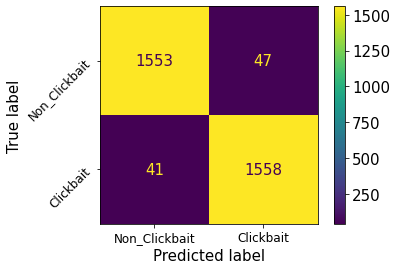

In [77]:
# Define the model
simple_rnn = Sequential()
simple_rnn.add(Embedding(input_dim = VOCAB_SIZE, output_dim = EMBEDDING_DIM, input_length = MAXLEN))
simple_rnn.add(SimpleRNN(16))
simple_rnn.add(Dense(2, activation='sigmoid'))

simple_rnn.compile(optimizer = RMSprop(learning_rate=(0.001)), 
             loss = SparseCategoricalCrossentropy(), 
             metrics = ['accuracy'])
simple_rnn_history1 = simple_rnn.fit(x = X_train_padded1, y = train_data1.labels.values, epochs = 10,
                callbacks = [TensorBoard(log_dir = "logs_rnn_basic"), 
                             EarlyStopping(patience = 2, restore_best_weights=True)],
                validation_data=(X_val_padded1, val_data1.labels.values), batch_size = 1024)



GetScoresNN(simple_rnn, X_train_padded1, X_val_padded1, train_data1.labels, val_data1.labels)
confusion_matrix_NN(simple_rnn, val_data1, X_val_padded1, labels_dict1, 'simple')


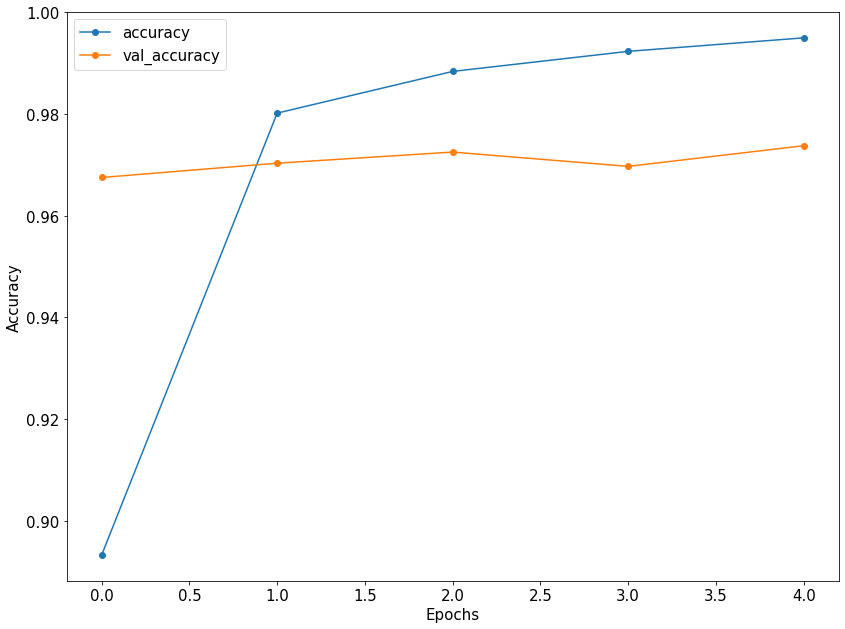

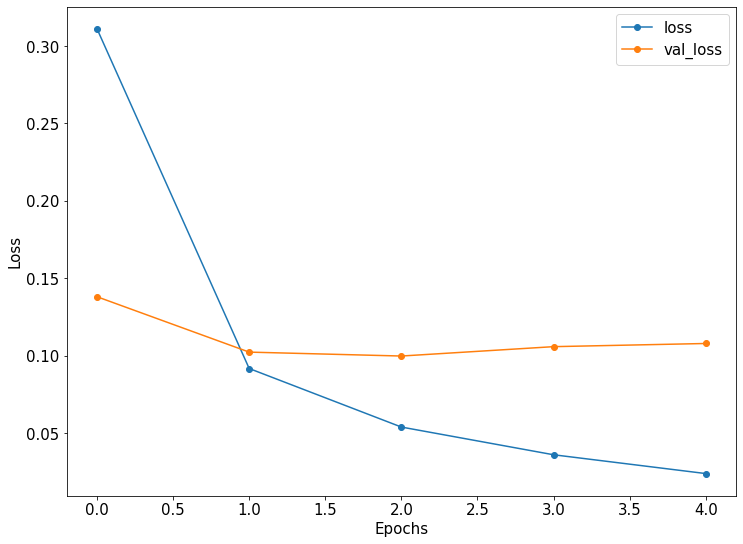

In [78]:
plot_accuracy_curve(simple_rnn_history1, 'SimpleRNN')
plot_loss_curve(simple_rnn_history1, 'SimpleRNN')

### A more complex RNN

In [79]:
rnn = Sequential([
    Embedding(input_dim = VOCAB_SIZE, output_dim = EMBEDDING_DIM, input_length = MAXLEN),
    SimpleRNN(64, return_sequences = True),
    Dropout(dropout),
    SimpleRNN(64, return_sequences = True),
    Dropout(dropout),
    SimpleRNN(32, return_sequences = True),
    Dropout(dropout),
    SimpleRNN(16),
    Dropout(dropout),
    Dense(4, activation='sigmoid')
])


In [80]:
rnn.compile(optimizer = RMSprop(learning_rate=(0.001)), 
             loss = SparseCategoricalCrossentropy(), 
             metrics = ['accuracy'])

In [81]:
rnn_history1 = rnn.fit(x = X_train_padded1, y = train_data1.labels.values, epochs = 10,
                callbacks = [TensorBoard(log_dir = "logs_rnn_basic"), 
                             EarlyStopping(patience = 2, restore_best_weights=True)],
                validation_data=(X_val_padded1, val_data1.labels.values), batch_size = 1024)

Epoch 1/10
25/25 [==============================] - 7s 126ms/step - loss: 0.5907 - accuracy: 0.7666 - val_loss: 0.1885 - val_accuracy: 0.9597
Epoch 2/10
25/25 [==============================] - 3s 110ms/step - loss: 0.1758 - accuracy: 0.9593 - val_loss: 0.1253 - val_accuracy: 0.9687
Epoch 3/10
25/25 [==============================] - 3s 106ms/step - loss: 0.0855 - accuracy: 0.9820 - val_loss: 0.1041 - val_accuracy: 0.9694
Epoch 4/10
25/25 [==============================] - 3s 105ms/step - loss: 0.0565 - accuracy: 0.9874 - val_loss: 0.0988 - val_accuracy: 0.9725
Epoch 5/10
25/25 [==============================] - 3s 104ms/step - loss: 0.0342 - accuracy: 0.9927 - val_loss: 0.1057 - val_accuracy: 0.9725
Epoch 6/10
25/25 [==============================] - 3s 109ms/step - loss: 0.0229 - accuracy: 0.9953 - val_loss: 0.1133 - val_accuracy: 0.9722


In [83]:
GetScoresNN(rnn, X_train_padded1, X_val_padded1, train_data1.labels, val_data1.labels)

   Accuracy  F1 Score  Precision    Recall  ROC_AUC
0  0.972491  0.972491    0.97251  0.972491        0
Inference time:  0.5879621505737305


<Figure size 864x864 with 0 Axes>

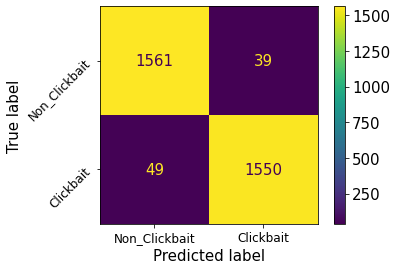

In [82]:
confusion_matrix_NN(rnn, val_data1, X_val_padded1, labels_dict1, 'RNN')

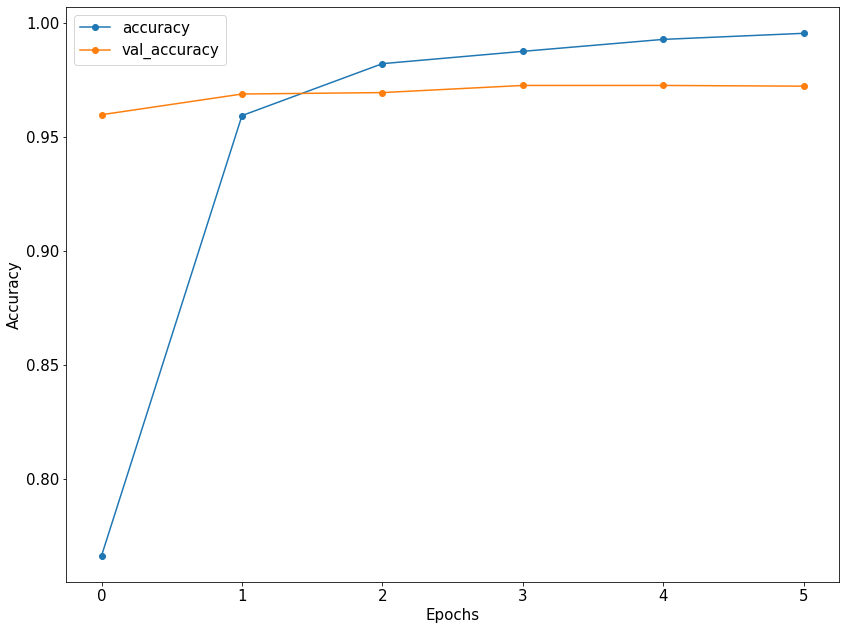

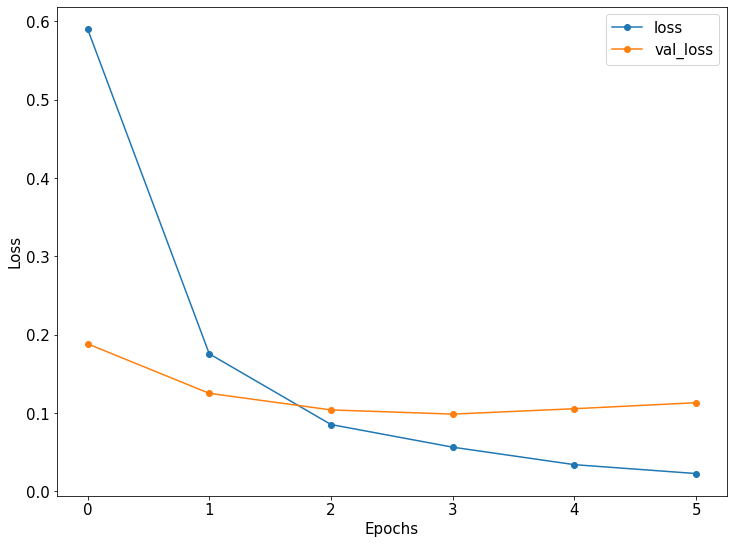

In [84]:
plot_accuracy_curve(rnn_history1, 'RNN')
plot_loss_curve(rnn_history1, 'RNN')

### Bi-Directional LSTM

In [85]:
def create_lstm(nb_outputs, activation="sigmoid", input_length=MAXLEN) :
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=input_length))
    model.add(Bidirectional(LSTM(128, return_sequences=True))) 
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(256))
    model.add(Dropout(dropout))
    model.add(Dense(128))
    model.add(Dropout(dropout))
    model.add(Dense(64))
    model.add(Dropout(dropout))
    model.add(Dense(nb_outputs, activation=activation))
    #model.summary()
    
    return model

In [87]:
lstm1 = create_lstm(2)

In [88]:
lstm1.compile(loss='sparse_categorical_crossentropy', #Sparse Categorical Crossentropy Loss because data is not one-hot encoded
              optimizer=RMSprop(learning_rate=(0.001)), 
              metrics=['accuracy']) 

In [89]:
lstm_history = lstm1.fit(x = X_train_padded1, y = train_data1.labels.values, epochs = 10,
          callbacks =  [EarlyStopping(patience = 2, restore_best_weights=True)],
          validation_data=(X_val_padded1, val_data1.labels.values), batch_size = 1024)

Epoch 1/10
25/25 [==============================] - 23s 657ms/step - loss: 0.3261 - accuracy: 0.8535 - val_loss: 0.0902 - val_accuracy: 0.9678
Epoch 2/10
25/25 [==============================] - 18s 724ms/step - loss: 0.0627 - accuracy: 0.9788 - val_loss: 0.0905 - val_accuracy: 0.9641
Epoch 3/10
25/25 [==============================] - 17s 656ms/step - loss: 0.0410 - accuracy: 0.9864 - val_loss: 0.0805 - val_accuracy: 0.9672
Epoch 4/10
25/25 [==============================] - 15s 599ms/step - loss: 0.0293 - accuracy: 0.9905 - val_loss: 0.0749 - val_accuracy: 0.9750
Epoch 5/10
25/25 [==============================] - 14s 573ms/step - loss: 0.0188 - accuracy: 0.9934 - val_loss: 0.0740 - val_accuracy: 0.9731
Epoch 6/10
25/25 [==============================] - 14s 556ms/step - loss: 0.0145 - accuracy: 0.9954 - val_loss: 0.1482 - val_accuracy: 0.9737
Epoch 7/10
25/25 [==============================] - 15s 601ms/step - loss: 0.0108 - accuracy: 0.9969 - val_loss: 0.1212 - val_accuracy: 0.9728

In [90]:
GetScoresNN(lstm1, X_train_padded1, X_val_padded1, train_data1.labels, val_data1.labels)

   Accuracy  F1 Score  Precision    Recall  ROC_AUC
0  0.973117  0.973111   0.973508  0.973117        0
Inference time:  3.11047101020813


<Figure size 864x864 with 0 Axes>

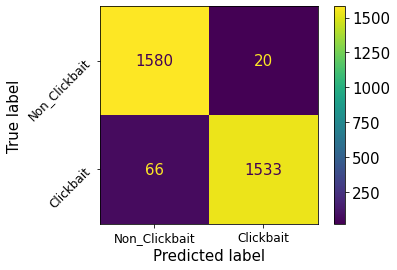

In [91]:
confusion_matrix_NN(lstm1, val_data1, X_val_padded1, labels_dict1, 'lstm')

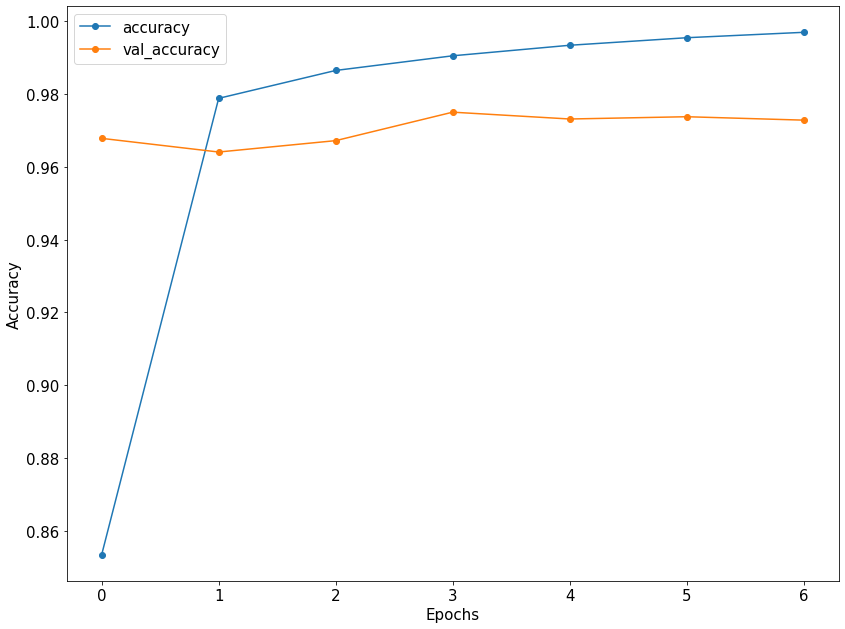

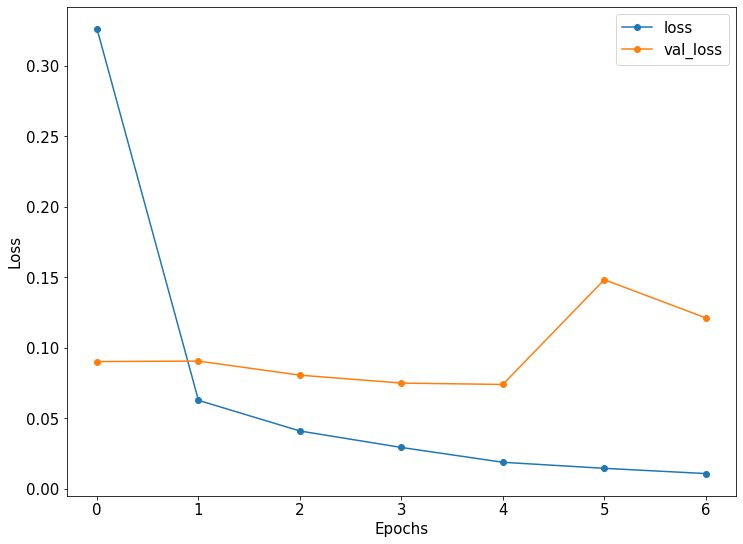

In [92]:
plot_accuracy_curve(lstm_history, 'lstm')
plot_loss_curve(lstm_history, 'lstm')